In [1]:
import matplotlib.pyplot as plt
from paths import get_paths
from _bootstrap import *
from polygon_processors import (
    UrbanRuralPolygonMerger,
    MultipartPolygonRelabeller,
    VoronoiProcessor,
    PolygonPlotter)

# Define base paths
input_dir, output_dir,  plots_dir = get_paths()

urban_path = "manzanas_apc_2023.shp"
rural_path = "microdatos_entidad.zip"

# Helper functions

def run_voronoi(processor, clean=False, densify=False, simplify=False, densify_dist=10):
  return processor.process(
      region_path=input_dir / "COMUNA_C17.shp",
      barrier_mask_path=input_dir / "hydrographic_network.shp",
      int_region_path=input_dir / "ZONA_C17.shp",
      clean_polys=clean,
      densify_bdry=densify,
      simplify_bdry=simplify,
      densify_distance=densify_dist,
      verbose=False
  )

def plot_target_from_gdf(gdf, block_id, bbox=None, pad=50, ax=None, **kwargs):
  target = gdf[gdf["block_id"].str.contains(block_id)]
  if bbox is None:
    bbox = target.total_bounds
  plotter = PolygonPlotter(gdf.copy())
  plotter.plot_target_with_context(target_gdf=target, bbox=bbox, pad=pad, ax=ax, **kwargs)

# Data preparation: Merge and relabel input polygons
merger = UrbanRuralPolygonMerger()
merged_data = merger.process(
    urban_path=str(input_dir / urban_path),
    rural_path=str(input_dir / rural_path)
)

multipart_processor = MultipartPolygonRelabeller(input_data=merged_data)
processed_polys = multipart_processor._relabel_multipart_blocks()

# Define target block ID and bounding box for all plots
target_block = "13111081001020"
bbox = processed_polys[processed_polys["block_id"].str.contains(target_block)].total_bounds

original_polys = processed_polys.copy()

# Example 1: Original input polygons (no preprocessing)

# Example 2: Voronoi without cleaning, densification, or simplification
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
voronoi_raw = run_voronoi(voronoi_processor, clean=False, densify=False, simplify=False)

# Example 3: Cleaned polygons (visualise only, no Voronoi yet)
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
region, subregion = voronoi_processor._prepare_region(
    input_dir / "COMUNA_C17.shp",
    input_dir / "hydrographic_network.shp",
    1
)
cleaned  = voronoi_processor._prepare_input_polygons(10, 5.5, subregion, "sregion_id")

# Example 4: Voronoi with cleaned polygons (no densify or simplify)
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
voronoi_clean = run_voronoi(voronoi_processor, clean=True, densify=False, simplify=False)

# Example 5: Cleaned polygons with 10m densification (visualisation only)
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
region, subregion = voronoi_processor._prepare_region(
    input_dir / "COMUNA_C17.shp",
    input_dir / "hydrographic_network.shp",
    1
)
cleaned_dens10 = voronoi_processor._prepare_input_polygons(10, 5.5, subregion, "sregion_id")
cleaned_dens10 = voronoi_processor._densify_polygons(10)

# Example 6: Voronoi with cleaned + densified polygons (10m)
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
voronoi_dens10 = run_voronoi(voronoi_processor, clean=True, densify=True, simplify=False, densify_dist=10)

# Example 7: Cleaned polygons with 5m densification (visualisation only)
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
region, subregion = voronoi_processor._prepare_region(
    input_dir / "COMUNA_C17.shp",
    input_dir / "hydrographic_network.shp",
    1
)
cleaned_dens5 = voronoi_processor._prepare_input_polygons(10, 5.5, subregion, "sregion_id")
cleaned_dens5 = voronoi_processor._densify_polygons(5)

# Example 8: Voronoi with cleaned + densified polygons (5m)
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
voronoi_dens5 = run_voronoi(voronoi_processor, clean=True, densify=True, simplify=False, densify_dist=5)

# Example 9: Voronoi with boundary simplification
voronoi_processor = VoronoiProcessor(processed_polys.copy(), region_id=13111)
voronoi_simp = run_voronoi(voronoi_processor, clean=True, densify=True, simplify=True, densify_dist=5)

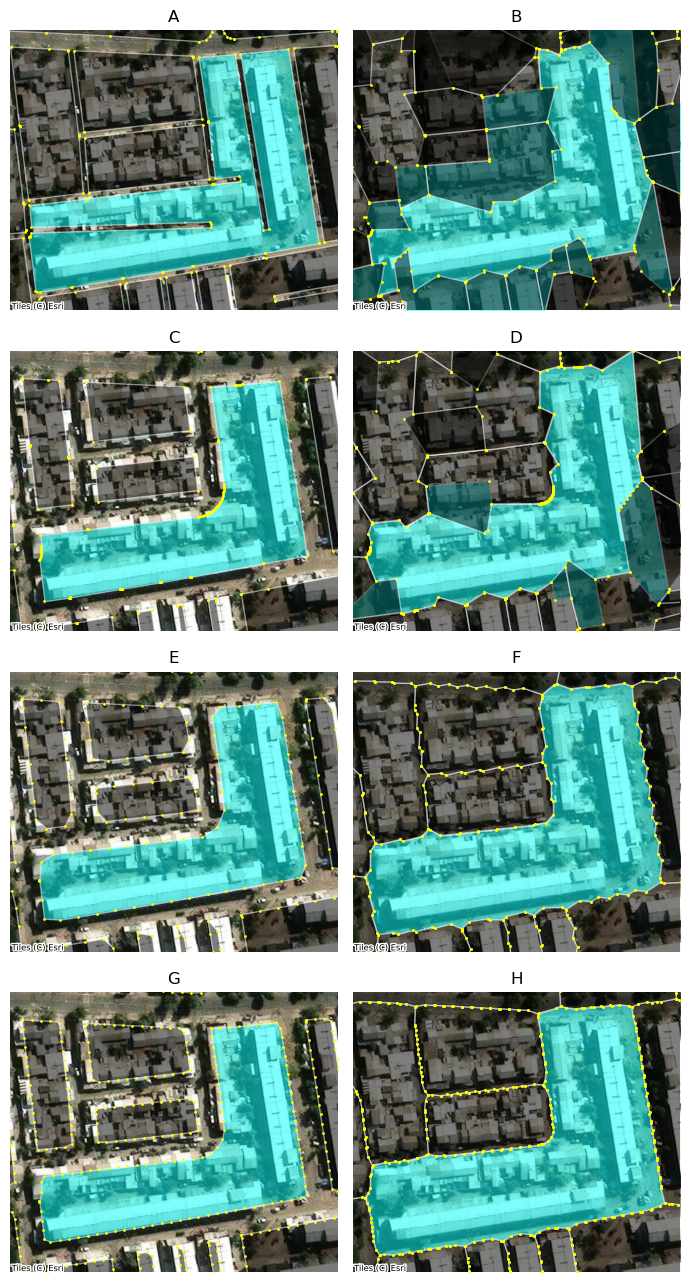

In [2]:
fig, axes = plt.subplots(
  nrows=4, ncols=2, figsize=(7, 13)
)
axes = axes.flatten()
plots = [
  ("A", original_polys),
  ("B", voronoi_raw),
  ("C", cleaned),
  ("D", voronoi_clean),
  ("E", cleaned_dens10),
  ("F", voronoi_dens10),
  ("G", cleaned_dens5),
  ("H", voronoi_dens5),
]

for ax, (label, gdf) in zip(axes, plots):
  plot_target_from_gdf(gdf, target_block, bbox=bbox, pad=10, ax=ax, plot_boundary_points=True)
  ax.set_title(label, loc='center', fontsize=12)
  ax.axis('off')

plt.tight_layout()

plt.savefig(plots_dir / "voronoi_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

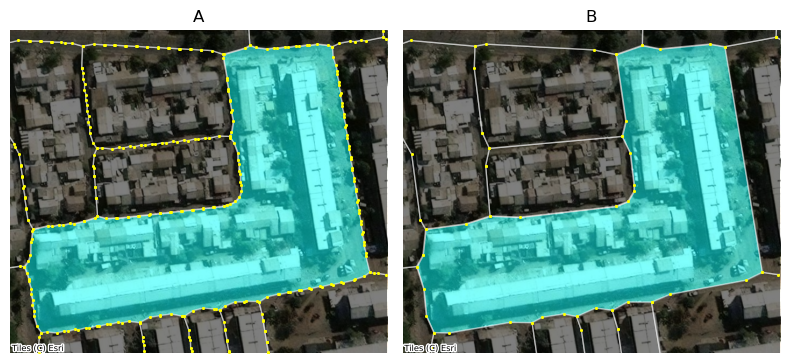

In [3]:
fig, axes = plt.subplots(
  nrows=1, ncols=2, figsize=(8, 4)
)
axes = axes.flatten()
plots = [
  ("A", voronoi_dens5),
  ("B", voronoi_simp)
]

for ax, (label, gdf) in zip(axes, plots):
  plot_target_from_gdf(gdf, target_block, bbox=bbox, pad=10, ax=ax, plot_boundary_points=True)
  ax.set_title(label, loc='center', fontsize=12)
  ax.axis('off')

plt.tight_layout()

plt.savefig(plots_dir / "voronoi_bdy_simplification.png", dpi=300, bbox_inches='tight')
plt.show()